This is my own try on the genetic algorithm to solve the knapsack problem before reading the suggested solution in the course book. An interesting discovery on dynamic mutation was explained in this notebook.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
#create random items to choose in knapsack problem
def fill_itemlist(n):
    items = []
    for i in range(n):
        value = int(random.random()*20)
        weight = int(random.random()*20)
        items.append([value,weight])
    return(items)

In [3]:
itemlist = fill_itemlist(20)

In [4]:
#create random genes
def initialization(population_size, items):
    genes = []
    for i in range(population_size):
        gene = []
        for j in items:
            gene.append(np.random.randint(2))
        genes.append(gene)
    return(genes)

In [5]:
init_population = (initialization(5,itemlist))

In [6]:
#returns 'fitness' of a member based on fitness function
def evaluate(member, max_weight, Q):
    sack_profit = 0
    sack_weight = 0
    for index, gene in enumerate(member):
        profit = gene*itemlist[index][0]
        weight = gene*itemlist[index][1] #gets position 1 (weight) from itemlist at corresponding gene position
        sack_profit += profit
        sack_weight += weight
    t = 1 if sack_weight > max_weight else 0
    fitness = sack_profit-(Q*t*(sack_weight-max_weight))
    return [fitness]

In [7]:
#returns a sorted list of scores so that scores[0,0] is index of best solution, scores [0,1] is score of best solution etc.
import operator
def evaluate_population(population):
    scores = []
    for index, member in enumerate(population):
        scores.append([index,evaluate(member,20,6)])
    scores = sorted(scores, key = operator.itemgetter(1), reverse=True)
    return scores

In [8]:
print(evaluate_population(init_population))

[[3, [-321]], [2, [-377]], [4, [-455]], [0, [-577]], [1, [-622]]]


The approach to the reproduction phase is a bit different from the approach used in the course book. The childs addopt each gene at random from it's parents, either the strongest or second strongest individual of a given poplulation.

The returned 'generation' is a list of lists of genes of 5 individuals: the 2 parents and 3 children that randomly inhibited genes from the parents.

In [9]:
#returns 'generation' of 3 childs with their parents
#selection phase is so simple we will not define it on it's own, function returns 2 parents with offspring of 3
def reproduction(population): 
    scorelist = evaluate_population(population)
    gene_1 = population[scorelist[0][0]]
    gene_2 = population[scorelist[1][0]]
    gene_n = []
    
    generation = [gene_1, gene_2]
    
    for child in range(3):
        gene_n = []
        for index, gene in enumerate(gene_1):
            gene_n.append(gene_1[index]) if random.random()<0.5 else gene_n.append(gene_2[index])
        generation.append(gene_n)
    return generation

For mutation the approach is a little different from the approach in the workbook: Genes are just flipped at random with parameterized probability.

In [10]:
#returns a mutated population, mutation_probability setting of 0.05 means each gene has a 5% probability of being flipped
def mutation(population, mutation_probability):
    generation = []
    for member in population:
        gene_n = []
        for gene in member:
            gene = abs(gene-1) if random.random()<mutation_probability else gene #flipping the gene bit
            gene_n.append(gene)
        generation.append(gene_n)
    return generation

This is the basis for the real difference from the other solutions: the 'DNA' of both parents is compared bit by bit. Each bit that is found to be equal for both parents is counted. This sum is a meassurement of similarity for the two parents.

In [11]:
def compare_parents(population):
    #parent_1 = evaluate_population(init_population)[0][0]
    #parent_2 = evaluate_population(init_population)[1][0]
    parent_1 = evaluate_population(population)[0][0]
    parent_2 = evaluate_population(population)[1][0]
    parent_1 = population[parent_1]
    parent_2 = population[parent_2]
    
    comparability = 0
    for index, gene in enumerate(parent_1):
        comparability = comparability +1 if gene == parent_2[index] else comparability
        
    return comparability

#for example compare the two best instances of the initial population which is probably low as they were randomly initiated
compare_parents(init_population)

12

One case example:
On the initial population we experiment letting it reproduce and then mutate 100 times. At first without differintiating in comparability of the parents, afterwards using the comparability to increase the likelihood of mutations:

In [12]:
gen = init_population
x=[]
y=[]
for i in range(100):
    gen = mutation(reproduction(gen),0.01)
    x.append(i)
    y.append(evaluate_population(gen)[0][1])  

Then we repeat the experiment with a dynamic parameter for likelihood of mutation

In [13]:
P_mut = 0.01
P_mut_comparable = 0.05

gen_m = init_population
x_m=[]
y_m=[]
for i in range(100):
    if compare_parents(gen_m)>18:
        P_mut = P_mut_comparable 
    gen_m = mutation(reproduction(gen_m),P_mut)
    x_m.append(i)
    y_m.append(evaluate_population(gen_m)[0][1])  

[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[21]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[35]


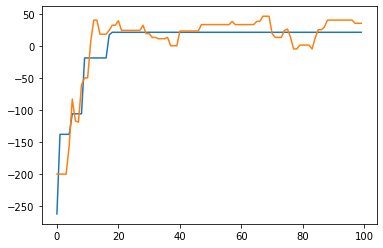

In [14]:
plt.plot(x,y)
plt.plot(x_m,y_m)
#The solution at iteration 100
print(gen[0])
print(evaluate_population(gen)[0][1])
print(gen_m[0])
print(evaluate_population(gen_m)[0][1])

The results vary but the plot of the mutated version seems to outperform it's static counterpart

To get a larger amount of results we repeat the experiment for n times by making a function to do repetitions of the experiment. The dynamic_mutation parameter is a boolean, when set to True it uses P_mut_comparable to increase the probability of mutations to happen.

In [15]:
def experiment(init_population, dynamic_mutation):
    gen_m = init_population
    P_mut = 0.01
    P_mut_comparable = 0.05 #when parents are alike mutation probability increases

    runs = 100
    max_score = 0
    for i in range (runs):
        P_mut_i = P_mut
        if(dynamic_mutation and compare_parents(gen_m)>18):
            P_mut_i = P_mut_comparable 
        gen_m = mutation(reproduction(gen_m),P_mut_i)
        score = evaluate_population(gen_m)[0][1]
        score = score[0]
        max_score = score if score>max_score else max_score
    return max_score

To get a result the itemlist to fill the knapsack is initialized 25 times. 25 times a new initial population is generated which is passed to reproduce and mutate with and without the dynamic mutation parameter.

The average score for the static mutation is:  55.44
The average score for the dynamic mutation is:  67.44


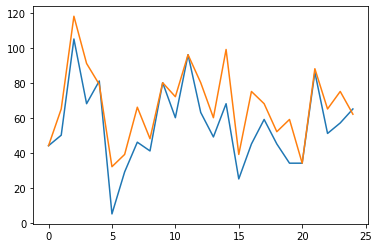

In [16]:
x = []
y0 = []
y1 = []
y = []
for exp in range(25):
    itemlist = fill_itemlist(20)
    init_population = initialization(5,itemlist)

    x.append(exp)
    y0.append(experiment(init_population, False))
    y1.append(experiment(init_population, True))

plt.plot(x,y0)
plt.plot(x,y1)
print("The average score for the static mutation is: ",sum(y0)/len(y0))
print("The average score for the dynamic mutation is: ",sum(y1)/len(y1))

Results may vary given the random states it shows, on average$^*$, the dynamic mutation (orange) outperforms the static mutation 


$*$Results may vary given the random state